In [4]:
import CentralStreamingModel.biskewt.skewt as st
import matplotlib.pyplot as plt
import numpy as np
import importlib
import seaborn as sns
from CentralStreamingModel.projection.wrap_projection import skewt_los_pdf
from scipy.integrate import simps
from scipy.stats import t, norm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [260]:
v_los = np.linspace(-30., 30., 100)


In [261]:
r = np.linspace(0.,100.,100)

In [297]:
vr_c = 0.
kappa = 43

In [384]:
skewness  = 6 * np.array([-0.22824317, -0.28700552, -0.32138441, -0.35153971, -0.37669294,
       -0.39699951, -0.41333292, -0.43523036, -0.45657978, -0.46591706,
       -0.47801316, -0.49701671, -0.50825189, -0.51864746, -0.52082757,
       -0.53601556, -0.53877632, -0.54976906, -0.55126538, -0.5550653 ,
       -0.5631011 , -0.56095105, -0.56149007, -0.56612626, -0.5673214 ,
       -0.56709971, -0.56794171, -0.56573163, -0.5666588 , -0.56737796,
       -0.56506297, -0.56416434, -0.55893042, -0.55710519, -0.55552553,
       -0.55618865, -0.54992267, -0.54579673, -0.54665099, -0.54356148,
       -0.53909907, -0.53456013, -0.53059565, -0.52647404, -0.5235053 ,
       -0.52315444, -0.51452832, -0.51199822, -0.5093639 , -0.50862004,
       -0.50103332, -0.49521253, -0.49631076, -0.4894739 , -0.48645358,
       -0.48212167, -0.47938453, -0.47522702, -0.47189685, -0.4651172 ,
       -0.4647294 , -0.46049525, -0.45830989, -0.45129085, -0.44834373,
       -0.44766817, -0.44401077, -0.43934931, -0.43936287, -0.43587342,
       -0.43427033, -0.42633883, -0.4248842 , -0.42185644, -0.42216103,
       -0.41851037, -0.41350228, -0.41254514, -0.40754044, -0.40601594,
       -0.40089972, -0.40083251, -0.40140987, -0.3929827 , -0.39649445,
       -0.39128072, -0.39197599, -0.39325319, -0.38432591, -0.38438263,
       -0.38420625, -0.38341299, -0.37708721, -0.37231451, -0.37708091,
       -0.37266914, -0.37191009, -0.36877539, -0.36953759, -0.36605502]) 

In [385]:
def w(r):
    return 0.1*r + 1.

def alpha(r):
    return 0.001*r - 0.4

def norm_pdf(v, loc, scale):
    return norm.pdf(v, loc = loc, scale = scale)  

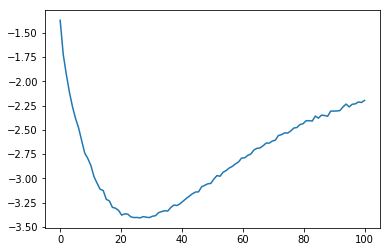

In [386]:
plt.plot(r,skewness)


In [387]:
def alpha(r,a,b,c):
    return a*np.sqrt(r) + b * r  + c

In [388]:
popt_skewness, pcov = curve_fit(alpha, r, skewness )

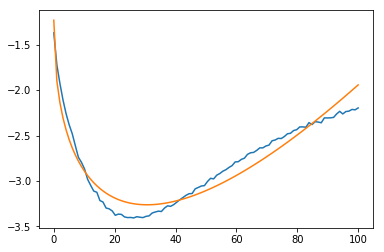

In [389]:
#plt.plot(r, alpha(r))
plt.plot(r,skewness)
plt.plot(r, alpha(r, *popt_skewness))

In [415]:
def find_gaussian_parameters(r, v_los):
    st_pdf = np.zeros((len(r), len(v_los)))
    gauss_pdf = np.zeros((len(r), len(v_los)))

    mean = np.zeros((len(r)))
    std = np.zeros_like(mean)

    for i, r_value in enumerate(r):

        st_pdf[i] =  truncated_skewt(v_los, vr_c, w(r_value), alpha(r_value, *popt_skewness), kappa)
        #st_pdf[i] /= simps(st_pdf[i], v_los)
        mean[i] = simps(st_pdf[i] * v_los, v_los)
        std[i] = np.sqrt(simps(st_pdf[i] * (v_los - mean[i])**2, v_los))

        gauss_pdf[i] = norm.pdf(v_los, loc = mean[i], scale = std[i])  
    return mean, std, st_pdf, gauss_pdf

def find_best_fit_gaussian(r, v_los):
    st_pdf = np.zeros((len(r), len(v_los)))
    gauss_pdf = np.zeros((len(r), len(v_los)))

    mean = np.zeros((len(r)))
    std = np.zeros_like(mean)


    for i, r_value in enumerate(r):

        st_pdf[i] =  truncated_skewt(v_los, vr_c, w(r_value), alpha(r_value, *popt_skewness), kappa)
        #st_pdf[i] /= simps(st_pdf[i], v_los)
        popt, pcov = curve_fit(norm_pdf, v_los, st_pdf[i])
        mean[i], std[i] = popt

        gauss_pdf[i] = norm.pdf(v_los, loc = mean[i], scale = std[i])  
    return mean, std, st_pdf, gauss_pdf

In [416]:
def oned_skewt(v, v_c, w, alpha, nu):
    
    arg = alpha/np.sqrt(w) * (v - v_c) * ((nu + 1)/((v - v_c)**2/w + nu))**0.5
    
    return 2 * t.pdf(v, df = nu, scale = w, loc = v_c) * t.cdf(arg, nu+1)

def truncated_skewt(v, v_c, w, alpha, nu):
    
    pdf = oned_skewt(v, v_c, w, alpha, nu)
    if hasattr(w, "__len__"):
        norm = []
        for i, w_value in enumerate(w):
            norm.append(simps(oned_skewt(v_los, v_c,w_value, alpha[i], nu), v_los))    
    else:
        norm = simps(oned_skewt(v_los, v_c,w, alpha, nu), v_los)
    return pdf/norm

In [417]:
mean, std, st_pdf, gauss_pdf = find_gaussian_parameters(r, v_los)
mean_bf, std_bf, st_pdf_bf, gauss_pdf_bf = find_best_fit_gaussian(r, v_los)

In [418]:
mean_interp = interp1d(r, mean)
std_interp = interp1d(r, std)

In [394]:
mean_interp_bf = interp1d(r, mean_bf)
std_interp_bf = interp1d(r, std_bf)

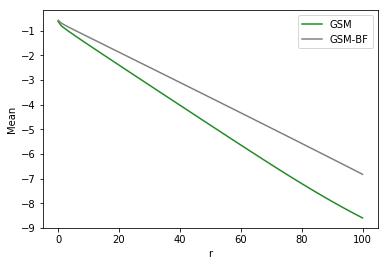

In [395]:
plt.plot(r, mean_interp(r), color = 'forestgreen',label = 'GSM')
plt.plot(r, mean_interp_bf(r), color='gray',label='GSM-BF')

plt.xlabel('r')
plt.ylabel('Mean')
plt.legend()

In [396]:
'''
from scipy.special import gamma

nu = 100
sk = -0.5
b = (nu/np.pi)**0.5 * gamma((nu-1)/2.)/gamma(nu/2.)
delta = sk/np.sqrt(1 + sk**2)
factor = nu/(nu - 2) - delta**2*b**2

print(factor)

w = 20.
v_c = 3.5

print(delta)
mean = v_c + w * delta * b

print(mean)
'''


'\nfrom scipy.special import gamma\n\nnu = 100\nsk = -0.5\nb = (nu/np.pi)**0.5 * gamma((nu-1)/2.)/gamma(nu/2.)\ndelta = sk/np.sqrt(1 + sk**2)\nfactor = nu/(nu - 2) - delta**2*b**2\n\nprint(factor)\n\nw = 20.\nv_c = 3.5\n\nprint(delta)\nmean = v_c + w * delta * b\n\nprint(mean)\n'

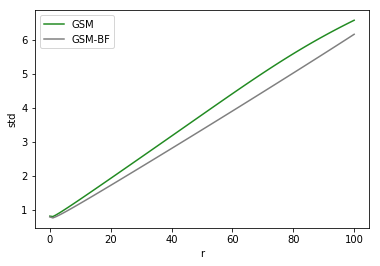

In [412]:
plt.plot(r, std_interp(r), color = 'forestgreen',label = 'GSM')
plt.plot(r, std_interp_bf(r), color='gray',label='GSM-BF')
#plt.plot(r, (w(r)), color='black',label='ST')

plt.xlabel('r')
plt.ylabel('std')
plt.legend()

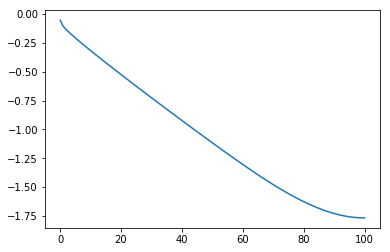

In [414]:
plt.plot(r, mean_interp(r) - mean_interp_bf(r))

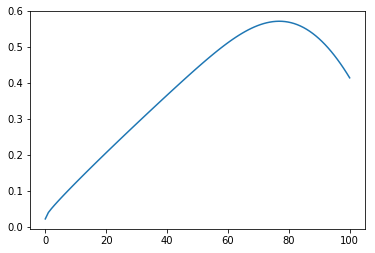

In [413]:
plt.plot(r, std_interp(r) - std_interp_bf(r))

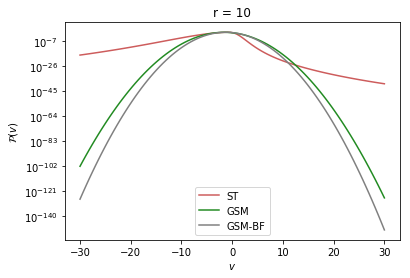

In [398]:
r_plot = 10
plt.title(f'r = {r_plot}')
plt.semilogy(v_los, st_pdf[r_plot], color='indianred', label = 'ST')
plt.semilogy(v_los, gauss_pdf[r_plot], color = 'forestgreen', label = 'GSM')
plt.plot(v_los, gauss_pdf_bf[r_plot], color = 'gray', label = 'GSM-BF')

plt.ylabel(r'$\mathcal{P}(v)$')
plt.xlabel(r'$v$')
plt.legend()

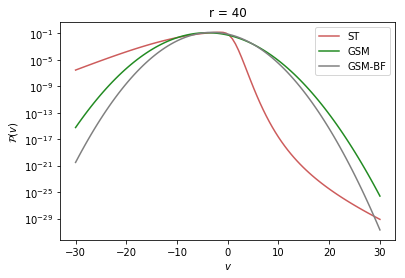

In [399]:
r_plot = 40
plt.title(f'r = {r_plot}')
plt.semilogy(v_los, st_pdf[r_plot], color='indianred', label = 'ST')
plt.semilogy(v_los, gauss_pdf[r_plot], color = 'forestgreen', label = 'GSM')
plt.plot(v_los, gauss_pdf_bf[r_plot], color = 'gray', label = 'GSM-BF')

plt.ylabel(r'$\mathcal{P}(v)$')
plt.xlabel(r'$v$')
plt.legend()

## ii) Just integrating the PDF

In [400]:
def integrand(r_parallel, pdf):
    return pdf(r_parallel, r_parallel)

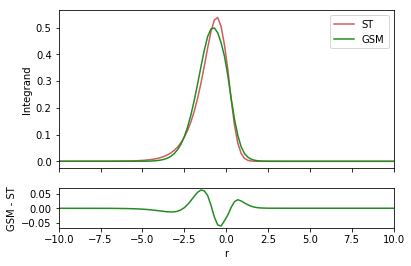

In [401]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})
ax1.plot(rparallel, integrand(rparallel, stsm), label = 'ST', color = 'indianred')
ax1.plot(rparallel, integrand(rparallel, gsm), label = 'GSM', color = 'forestgreen')
ax2.plot(rparallel, integrand(rparallel, gsm)-integrand(rparallel, stsm),
         label = 'GSM', color = 'forestgreen')
ax1.set_ylabel('Integrand')
ax2.set_ylabel('GSM - ST')

ax2.set_xlabel('r')
plt.xlim(-10,10)
ax1.legend()

## iii) With minus

In [402]:
def gsm(r, v, truncate = False):
    
    return norm.pdf(v, loc = mean_interp(abs(r)), scale = std_interp(abs(r)))

def gsm_bf(r, v, truncate = False):
    
    return norm.pdf(v, loc = mean_interp_bf(abs(r)), scale = std_interp_bf(abs(r)))

def stsm(r, v, truncate = False):
    pdf_contribution = np.zeros_like(v)
    if truncate:
        threshold = (v > np.min(v_los)) & (v < np.max(v_los))

        pdf_contribution[threshold] = truncated_skewt( v, vr_c,w(abs(r)), alpha(abs(r), *popt_skewness),
                                                                                kappa)[threshold]
    else:
        pdf_contribution = oned_skewt(v, vr_c,w(abs(r)), alpha(abs(r), *popt_skewness),
                                                               kappa)
    return pdf_contribution

In [403]:

def integrand_minus(r_parallel, pdf, s):
    v = (s - r_parallel) * np.sign(r_parallel)
    return pdf(r_parallel, v, truncate=True)

In [404]:
def integrate(integrand,r_parallel):
    left = r_parallel < 0.
    right = r_parallel > 0.
    
    return simps(integrand[left], r_parallel[left]) + simps(integrand[right], r_parallel[right])

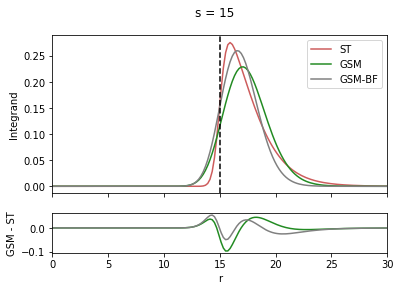

In [405]:
rparallel = np.linspace(-100., 100., 1000)
s = 15

fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})
plt.suptitle(f's = {s}')
ax1.plot(rparallel, integrand_minus(rparallel, stsm,s), label = 'ST', color = 'indianred')
ax1.plot(rparallel, integrand_minus(rparallel, gsm,s), label = 'GSM', color = 'forestgreen')
ax1.plot(rparallel, integrand_minus(rparallel, gsm_bf,s), label = 'GSM-BF', color = 'gray')

ax1.axvline(x=s, color='black', linestyle='dashed')
ax2.plot(rparallel, integrand_minus(rparallel, gsm,s)-integrand_minus(rparallel, stsm,s),
         label = 'GSM', color = 'forestgreen')
ax2.plot(rparallel, integrand_minus(rparallel, gsm_bf,s)-integrand_minus(rparallel, stsm,s),
         label = 'GSM', color = 'gray')
ax1.set_ylabel('Integrand')
ax2.set_ylabel('GSM - ST')

ax2.set_xlabel('r')
plt.xlim(0,30)
ax1.legend()

In [406]:
integrate(integrand_minus(rparallel,stsm,s), rparallel)

1.09459333536131

In [407]:
integrate(integrand_minus(rparallel,gsm,s), rparallel)

1.0941839994121305

In [408]:
integrate(integrand_minus(rparallel,gsm_bf,s), rparallel)

1.068861333849076

In [409]:
s_range = np.linspace(0.5,20.5,15)
gauss_int, gauss_int_bf, st_int = [], [], []
for s_value in s_range:
    st_int.append(integrate(integrand_minus(rparallel,stsm,s_value), rparallel))
    gauss_int.append(integrate(integrand_minus(rparallel,gsm,s_value), rparallel))
    gauss_int_bf.append(integrate(integrand_minus(rparallel,gsm_bf,s_value), rparallel))    

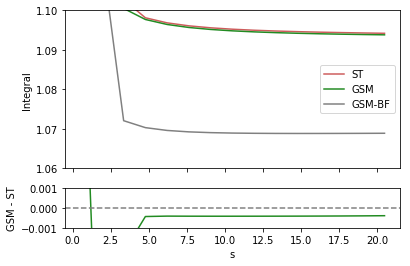

In [410]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})
ax1.plot(s_range,st_int, label = 'ST', color = 'indianred')
ax1.plot(s_range, gauss_int, label = 'GSM', color = 'forestgreen')
ax1.plot(s_range, gauss_int_bf, label = 'GSM-BF', color = 'gray')

ax2.plot(s_range, np.asarray(gauss_int_bf) - np.asarray(st_int),
         label = 'GSM-BF', color = 'gray')

ax2.plot(s_range, np.asarray(gauss_int) - np.asarray(st_int),
         label = 'GSM', color = 'forestgreen')
ax1.set_ylabel('Integral')
ax2.set_ylabel('GSM - ST')

ax2.set_xlabel('s')
ax2.set_ylim(-0.001,0.001)
ax1.set_ylim(1.06,1.1)
ax2.axhline(y = 0., linestyle='dashed', color='gray')
ax1.legend()

# Without truncating the PDF

In [1594]:
alpha = -0.5

print(alpha/np.sqrt(1+alpha**2))

-0.4472135954999579
